In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.insert(0, "../..")
import scirpy as ir
import scanpy as sc
from glob import glob
import pandas as pd
import tarfile
import anndata
import warnings
from numba import NumbaPerformanceWarning

# ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# suppress "storing XXX as categorical" warnings.
anndata.logging.anndata_logger.setLevel("ERROR")

In [2]:
# Load the TCR data
adata_tcr = ir.io.read_10x_vdj(
    "example_data/liao-2019-covid19/GSM4385993_C144_filtered_contig_annotations.csv.gz"
)

# Load the associated transcriptomics data
adata = sc.read_10x_h5(
    "example_data/liao-2019-covid19/GSM4339772_C144_filtered_feature_bc_matrix.h5"
)

This particular sample only has a detected TCR for a small fraction of the cells: 

In [3]:
adata_tcr.shape

(136, 0)

In [4]:
adata.shape

(3716, 33539)

In [5]:
ir.pp.merge_with_tcr(adata, adata_tcr)

Now, we can use TCR-related variables together with the gene expression data. 
Here, we visualize the cells with a detected TCR on the UMAP plot. 
It is reassuring that the TCRs coincide with the T-cell marker gene CD3. 

/opt/hostedtoolcache/Python/3.7.7/x64/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


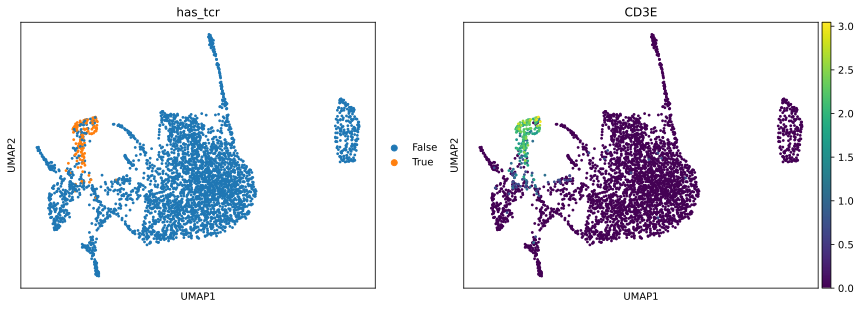

In [6]:
sc.pp.log1p(adata)
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["has_tcr", "CD3E"])

In [7]:
# extract data
with tarfile.open("example_data/chung-park-2017.tar.bz2", "r:bz2") as tar:
    tar.extractall("example_data/chung-park-2017")

In [8]:
# Load transcriptomics data from count matrix
expr_chung = pd.read_csv("example_data/chung-park-2017/counts.tsv", sep="\t")
# anndata needs genes in columns and samples in rows
expr_chung = expr_chung.set_index("Geneid").T
adata = sc.AnnData(expr_chung)
adata.shape

(563, 23438)

In [9]:
# Load TCR data and merge it with transcriptomics data
adata_tcr = ir.io.read_tracer("example_data/chung-park-2017/tracer/")
ir.pp.merge_with_tcr(adata, adata_tcr)

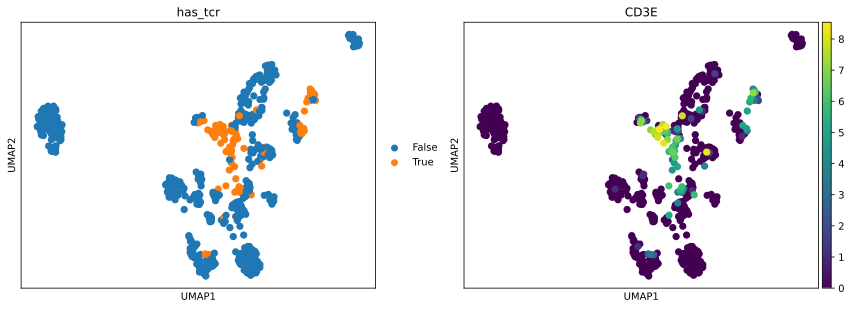

In [10]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=3000)
sc.pp.log1p(adata)
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["has_tcr", "CD3E"])

In [11]:
adata = ir.io.read_airr(["example_data/immunesim_airr/immunesim_tra.tsv", "example_data/immunesim_airr/immunesim_trb.tsv"])

In [12]:
ir.pp.tcr_neighbors(adata, metric="alignment", cutoff=25, receptor_arms="any", dual_tcr="primary_only")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1129.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 89%|████████▉ | 89/100 [00:00<00:00, 887.22it/s]

100%|██████████| 100/100 [00:00<00:00, 955.28it/s]


  0%|          | 0/142 [00:00<?, ?it/s]

100%|██████████| 142/142 [00:00<00:00, 70119.04it/s]


  0%|          | 0/147 [00:00<?, ?it/s]

100%|██████████| 147/147 [00:00<00:00, 64145.10it/s]


  0%|          | 0/278 [00:00<?, ?it/s]

100%|██████████| 278/278 [00:00<00:00, 92321.18it/s]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf49c09f90>],
      dtype=object)

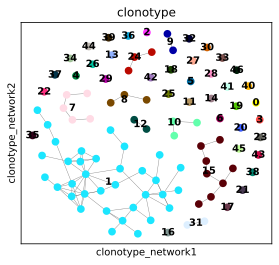

In [13]:
ir.tl.define_clonotypes(adata)
ir.tl.clonotype_network(adata, layout="fr")
ir.pl.clonotype_network(adata, color="clonotype", panel_size=(4, 4))

In [14]:
tcr_table = pd.read_csv(
    "example_data/chung-park-2017/tcr_table.tsv",
    sep="\t",
    index_col=0,
    na_values=["None"],
    true_values=["True"],
)
tcr_table

cell_id       cdr3_alpha  \
0   SRR2973278  AVSDIHASGGSYIPT   
1   SRR2973305      AVVTGANSKLT   
2   SRR2973371      ALKRTGNTPLV   
3   SRR2973377     ATDPETSGSRLT   
4   SRR2973403    AVRGATDSWGKFQ   
..         ...              ...   
85  SRR5023618              NaN   
86  SRR5023621     AENSGGSNYKLT   
87  SRR5023626      ALRIGSNYKLT   
88  SRR5023633              NaN   
89  SRR5023639              NaN   

                                    cdr3_nt_alpha  count_alpha   v_alpha  \
0   GCTGTTTCGGATATTCATGCATCAGGAGGAAGCTACATACCTACA      9.29463    TRAV21   
1               GCTGTGGTAACTGGAGCCAATAGTAAGCTGACA     89.45740    TRAV22   
2               GCTCTGAAAAGAACAGGAAACACACCTCTTGTC    431.96500   TRAV9-2   
3            GCTACGGACCCAGAAACCAGTGGCTCTAGGTTGACC    772.43600    TRAV17   
4         GCTGTGAGAGGAGCAACTGACAGCTGGGGGAAATTCCAG     95.63640     TRAV3   
..                                            ...          ...       ...   
85                                            NaN          NaN       NaN   
86           GCAGAGAATAGTGGAGGTAGCAACTATAAACTGACA    512.63000  TRAV13-2   
87              GCTCTGAGAATCGGTAGCAACTATAAACTGACA     12.51630   TRAV9-2   
88                                            NaN          NaN       NaN   
89                                            NaN          NaN       NaN   

   j_alpha       cdr3_beta                                cdr3_nt_beta  \
0    TRAJ6     ASSWWQNTEAF           GCCAGCAGCTGGTGGCAGAACACTGAAGCTTTC   
1   TRAJ56             NaN                                         NaN   
2   TRAJ29    ASRSRDSGEPQH        GCCAGCAGGAGCAGGGACAGCGGAGAGCCCCAGCAT   
3   TRAJ58             NaN                                         NaN   
4   TRAJ24      SVQTSEYEQY              AGCGTCCAGACTAGCGAGTACGAGCAGTAC   
..     ...             ...                                         ...   
85     NaN  ASSDSPFSSYNEQF  GCCAGCAGTGACTCGCCCTTTAGCTCCTACAATGAGCAGTTC   
86  TRAJ53     ASSPDGGGGYT           GCCAGCAGCCCTGATGGGGGAGGGGGCTACACC   
87  TRAJ53             NaN                                         NaN   
88     NaN   ASGLGQSVGGTQY     GCTAGTGGCCTAGGGCAGTCGGTAGGAGGGACCCAGTAC   
89     NaN  ASSKGSLGPAGELF  GCCAGCAGCAAAGGATCGCTGGGGCCCGCCGGGGAGCTGTTT   

    count_beta    v_beta d_beta   j_beta  productive_alpha  productive_beta  
0      37.5984   TRBV5-1    NaN  TRBJ1-1              True             True  
1          NaN       NaN    NaN      NaN              True             True  
2     952.0230  TRBV10-2  TRBD1  TRBJ1-5              True             True  
3          NaN       NaN    NaN      NaN              True             True  
4     205.8330  TRBV29-1  TRBD2  TRBJ2-7              True             True  
..         ...       ...    ...      ...               ...              ...  
85    864.4550   TRBV6-4    NaN  TRBJ2-1              True             True  
86    805.2010   TRBV7-3  TRBD2  TRBJ1-2              True             True  
87         NaN       NaN    NaN      NaN              True             True  
88     18.4273  TRBV12-5  TRBD2  TRBJ2-5              True             True  
89    905.9260  TRBV21-1  TRBD1  TRBJ2-2              True             True  

[90 rows x 14 columns]

In [15]:
tcr_cells = []
for idx, row in tcr_table.iterrows():
    cell = ir.io.TcrCell(cell_id=row["cell_id"])
    alpha_chain = ir.io.TcrChain(
        chain_type="TRA",
        cdr3=row["cdr3_alpha"],
        cdr3_nt=row["cdr3_nt_alpha"],
        expr=row["count_alpha"],
        v_gene=row["v_alpha"],
        j_gene=row["j_alpha"],
        is_productive=row["productive_alpha"],
    )
    beta_chain = ir.io.TcrChain(
        chain_type="TRB",
        cdr3=row["cdr3_beta"],
        cdr3_nt=row["cdr3_nt_beta"],
        expr=row["count_beta"],
        v_gene=row["v_beta"],
        d_gene=row["d_beta"],
        j_gene=row["j_beta"],
        is_productive=row["productive_beta"],
    )
    cell.add_chain(alpha_chain)
    cell.add_chain(beta_chain)
    tcr_cells.append(cell)

In [16]:
adata_tcr = ir.io.from_tcr_objs(tcr_cells)

In [17]:
# We can re-use the transcriptomics data from above...
adata = sc.AnnData(expr_chung)
# ... and merge it with the TCR data
ir.pp.merge_with_tcr(adata, adata_tcr)

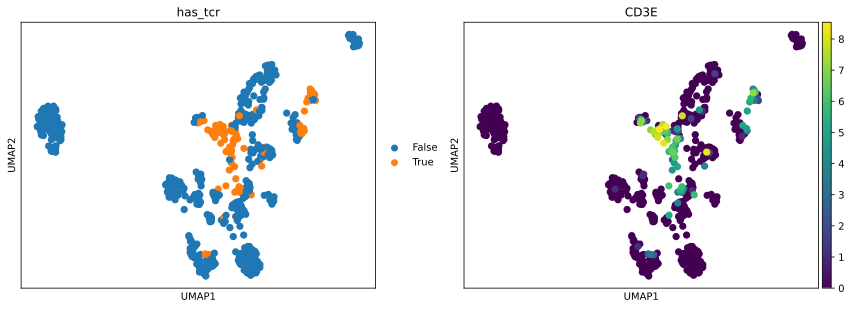

In [18]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=3000)
sc.pp.log1p(adata)
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["has_tcr", "CD3E"])

In [19]:
# define sample metadata. Usually read from a file.
samples = {
    "C144": {"group": "mild"},
    "C146": {"group": "severe"},
    "C149": {"group": "healthy control"},
}

In [20]:
# Create a list of AnnData objects (one for each sample)
adatas = []
for sample, sample_meta in samples.items():
    gex_file = glob(f"example_data/liao-2019-covid19/*{sample}*.h5")[0]
    tcr_file = glob(f"example_data/liao-2019-covid19/*{sample}*.csv.gz")[0]
    adata = sc.read_10x_h5(gex_file)
    adata_tcr = ir.io.read_10x_vdj(tcr_file)
    ir.pp.merge_with_tcr(adata, adata_tcr)
    adata.obs["sample"] = sample
    adata.obs["group"] = sample_meta["group"]
    # concatenation only works with unique gene names
    adata.var_names_make_unique()
    adatas.append(adata)

In [21]:
# Merge anndata objects
adata = adatas[0].concatenate(adatas[1:])

The data is now integrated in a single object. 
Again, the detected TCRs coincide with `CD3E` gene expression. 
We clearly observe batch effects between the samples -- for a meaningful downstream analysis further 
processing steps such as highly-variable gene filtering and batch correction are necessary. 

In [22]:
sc.pp.log1p(adata)
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["has_tcr", "CD3E", "sample"])